### Preamble

In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from typing import NamedTuple, Callable
from gpflow.config import default_float

from utils.plotting import *
from gpflow_sampling.samplers import location_scale, finite_fourier, decoupled
from thompson_sampling.utils import find_top_k
from thompson_sampling.tasks import RandomFourierTask
from thompson_sampling.optimizers import ThompsonSamplingBandit
from thompson_sampling.thompson_samplers import ThompsonSampler, PathwiseThompsonSampler

In [2]:
%matplotlib inline
set_default_rcParams(plt, fontsize=14, usetex=True)

In [3]:
SEED = 0
np.random.seed(SEED)
tf.random.set_seed(SEED)

###  Problem setup

In [4]:
flags = AttrDict()    # some minor book-keeping; the <AttrDict> 
results = AttrDict()  # class is imported from utils/plotting

In [5]:
class Flags(NamedTuple):
    """
    Settings used by Thompson samplers etc.
    """
    eval_limit: int = 256  # num. allocated evaluations
    par_limit: int = 1  # num. parallel evaluations
    batch_size: int = 1000  # num. locations to independently sample
    num_batches: int = 100  # num. batches from which to construct candidate set
    num_candidates: int = 1000  # num. jointly sampled locations used to pick query
    num_basis_init: int = 256  # initial num. of basis functions

In [6]:
ndims = 4
kernel = gpflow.kernels.Matern52(lengthscales=0.1 * np.sqrt(ndims), variance=1.0)
task = RandomFourierTask(kernel=kernel, input_dim=ndims, variance=1e-3)

X = tf.random.uniform(shape=[task.input_dim, task.input_dim], dtype=default_float())
model = gpflow.models.GPR(data=(X, task(X)),
                          kernel=kernel,
                          mean_function=lambda X: 0.0,
                          noise_variance=task.variance)

### Random search baseline

In [7]:
flags.rand = Flags(par_limit=task.input_dim)
num_random = flags.rand.eval_limit - len(model.data[0])
X = tf.random.uniform([num_random, task.input_dim], dtype=default_float())
results.rand = tuple(map(np.vstack, zip(model.data, (X, task(X)))))

###  Thompson sampling (location scale)

In [8]:
def run_thompson_sampling_locscale(flags, task, model):
    initial_data = model.data
    num_initial = len(initial_data[0])
    step_iterator = range(num_initial, flags.eval_limit, flags.par_limit)
    for _ in tqdm(step_iterator):
        budget_left = flags.eval_limit - len(model.data[0])
        num_choices = min(flags.par_limit, budget_left)
        sampler = location_scale(model,
                                 model.kernel,
                                 sample_shape=[num_choices])

        bandit = ThompsonSampler(sampler=sampler,
                                 input_dim=task.input_dim,
                                 batch_size=flags.batch_size,
                                 num_batches=flags.num_batches,
                                 num_candidates=flags.num_candidates)
    
        X = bandit(num_choices=num_choices)
        y = task(X)
        model.data = tuple(map(np.vstack, zip(model.data, (X, y))))
    
    final_data = model.data
    model.data = initial_data  # reset to avoid side effects
    return final_data

In [9]:
flags.loc = Flags(par_limit=task.input_dim, num_candidates=1000)
results.loc = run_thompson_sampling_locscale(flags.loc, task, model)

###  Thompson sampling (random Fourier)

In [10]:
def run_thompson_sampling_rff(flags, task, model):
    initial_data = model.data
    num_initial = len(initial_data[0])
    step_iterator = range(num_initial, flags.eval_limit, flags.par_limit)
    for _ in tqdm(step_iterator):
        budget_left = flags.eval_limit - len(model.data[0])
        num_choices = min(flags.par_limit, budget_left)
        num_basis = flags.num_basis_init + len(model.data[0]) # b = m + l
        sampler = finite_fourier(model,
                                 model.kernel, 
                                 sample_shape=[num_choices],
                                 num_basis=num_basis)
        
        bandit = PathwiseThompsonSampler(sampler=sampler,
                                         input_dim=task.input_dim,
                                         batch_size=flags.batch_size,
                                         num_batches=flags.num_batches,
                                         num_candidates=flags.num_candidates)

        X = bandit(num_choices=num_choices)
        y = task(X)
        model.data = tuple(map(np.vstack, zip(model.data, (X, y))))
    
    final_data = model.data
    model.data = initial_data  # reset to avoid side effects
    return final_data

In [11]:
flags.rff = Flags(par_limit=task.input_dim, num_candidates=32, batch_size=250)
results.rff = run_thompson_sampling_rff(flags.rff, task, model)

###  Thompson sampling (decoupled)

In [12]:
def run_thompson_sampling_decoupled(flags, task, model):
    initial_data = model.data
    num_initial = len(initial_data[0])
    step_iterator = range(num_initial, flags.eval_limit, flags.par_limit)
    for _ in tqdm(step_iterator):
        budget_left = flags.eval_limit - len(model.data[0])
        num_choices = min(flags.par_limit, budget_left)

        sampler = decoupled(model,
                            model.kernel, 
                            sample_shape=[num_choices],
                            num_basis=flags.num_basis_init)
        
        bandit = PathwiseThompsonSampler(sampler=sampler,
                                         input_dim=task.input_dim,
                                         batch_size=flags.batch_size,
                                         num_batches=flags.num_batches,
                                         num_candidates=flags.num_candidates)

        X = bandit(num_choices=num_choices)
        y = task(X)
        model.data = tuple(map(np.vstack, zip(model.data, (X, y))))
    
    final_data = model.data
    model.data = initial_data  # reset to avoid side effects
    return final_data

In [13]:
flags.dec = flags.rff  # use the same settings as RFF
results.dec = run_thompson_sampling_decoupled(flags.dec, task, model)

### Visualize performance

In [14]:
def estimate_fmin(task, num_starts=1024, num_batches=1024, batch_size=1024, compile=True):
    """
    Use gradients to directly estimate minimum (only used for estimating regret).
    """
    def batch_provider():
        batch_shape = [batch_size, task.input_dim]
        for _ in range(num_batches):
            yield tf.random.uniform(batch_shape, dtype=default_float())

    def _fn(xvals):
        return tf.squeeze(task(xvals, noisy=False), axis=-1)

    # Find starting positions using, e.g., random search
    fn = tf.function(_fn) if compile else _fn
    top_xvals, top_fvals = find_top_k(fn=fn,
                                      batch_provider=batch_provider,
                                      k=num_starts,
                                      sign='-')

    # Multi-start optimization
    xvars = tf.Variable(top_xvals, constraint=lambda x: tf.clip_by_value(x, 0, 1))
    bounds = np.full([tf.size(xvars), 2], [0.0, 1.0])
    
    def closure():
        return tf.reduce_sum(fn(xvars))

    optimizer = gpflow.optimizers.Scipy()
    _ = optimizer.minimize(closure=closure, variables=[xvars], bounds=bounds)

    fvals = fn(xvars)
    argmin = int(tf.argmin(fvals))
    return fvals[argmin], xvars[argmin]

fmin, _ = estimate_fmin(task)

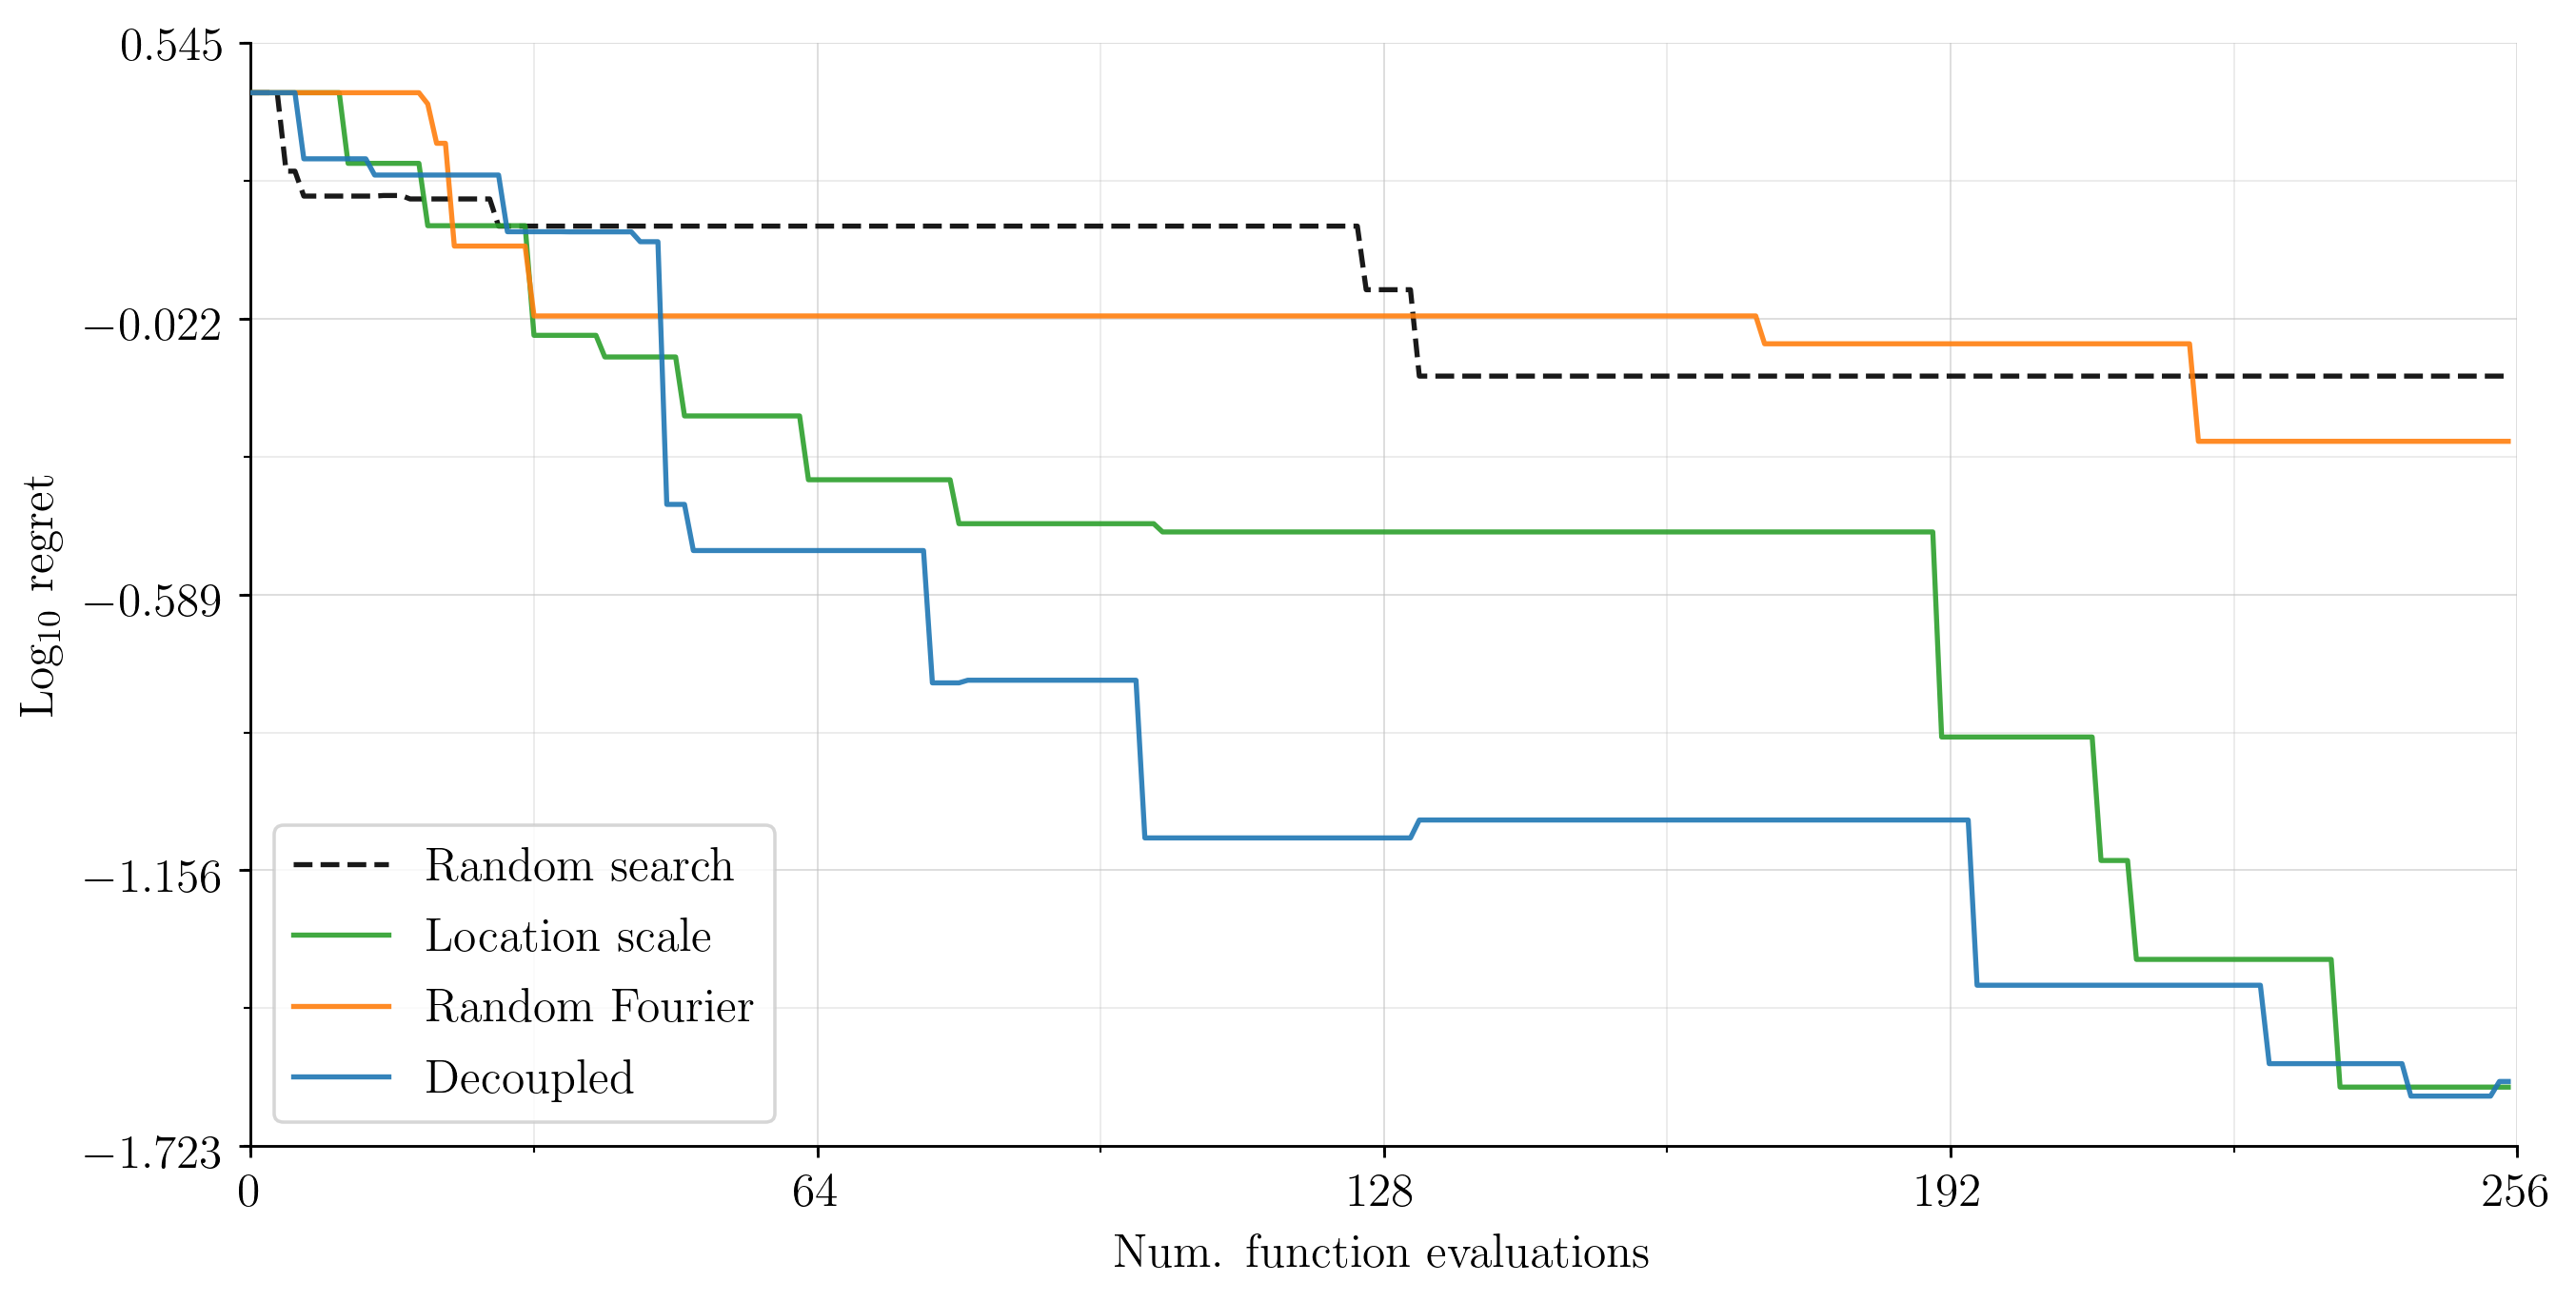

In [15]:
style = AttrDict()
style.rand = ObjectStyle(label='Random search', color='k', linestyle='--')
style.loc = ObjectStyle(label='Location scale', color='tab:green')
style.rff = ObjectStyle(label='Random Fourier', color='tab:orange')
style.dec = ObjectStyle(label='Decoupled', color='tab:blue')

fig, ax = plt.subplots(figsize=(12, 6))
with set_temporary_ax(ax):
    for name, (X, y) in results.items():
        best_yval = np.minimum.accumulate(y)
        best_mask = best_yval == y.T
        best_xval = X[np.where(best_mask)[1]]
        best_fval = task(best_xval, noisy=False)
        log_regret = np.log10(best_fval - fmin)
        plot_line(range(len(X)), log_regret, **style[name])
        
    ax.set_xlabel('Num. function evaluations')
    ax.set_ylabel('Log$_{10}$ regret')
    ax.legend(loc='best')
    format_axes(xlim=(0, 256), num_major=5, num_minor=9, grid='both', despine=True)